# **Twitter Hate Speech Detection**

# Importing Libraries

In [1]:
pip install wordcloud lazypredict

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, plot_precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from lazypredict.Supervised import LazyClassifier, LazyRegressor
import pickle
import time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings 
warnings.filterwarnings('ignore')

/kaggle/input/twitter-hate-speech/train_E6oV3lV.csv
/kaggle/input/twitter-hate-speech/test_tweets_anuFYb8.csv
/kaggle/input/cyberbullying-dataset/twitter_sexism_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/youtube_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/kaggle_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/aggression_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/toxicity_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/attack_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/twitter_racism_parsed_dataset.csv


# Loading Dataset 1

In [3]:
train1 = pd.read_csv('/kaggle/input/twitter-hate-speech/train_E6oV3lV.csv')
print("Training Set 1 :"% train1.columns, train1.shape)
test1 = pd.read_csv('/kaggle/input/twitter-hate-speech/test_tweets_anuFYb8.csv')
print("Test Set 1 :"% test1.columns, test1.shape)

print('Train Set 1 -----')
print(train1.isnull().sum())
print('Test Set 1 -----')
print(test1.isnull().sum())
train1.head()

Training Set 1 : (31962, 3)
Test Set 1 : (17197, 2)
Train Set 1 -----
id       0
label    0
tweet    0
dtype: int64
Test Set 1 -----
id       0
tweet    0
dtype: int64


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# Loading Dataset 2

In [4]:
df = pd.read_csv('/kaggle/input/cyberbullying-dataset/toxicity_parsed_dataset.csv')
df.head()

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,This: :One can make an analogy in mathematical...,0.90,0.10,0
1,1,` :Clarification for you (and Zundark's righ...,1.00,0.00,0
2,2,Elected or Electoral? JHK,1.00,0.00,0
3,3,`This is such a fun entry. Devotchka I once...,1.00,0.00,0
4,4,Please relate the ozone hole to increases in c...,0.80,0.20,0


# Selecting only useful columns of Dataset2

In [5]:
df = df[['index','oh_label','Text']]
df.head()

,index,oh_label,Text
0,0,0,This: :One can make an analogy in mathematical...
1,1,0,` :Clarification for you (and Zundark's righ...
2,2,0,Elected or Electoral? JHK
3,3,0,`This is such a fun entry. Devotchka I once...
4,4,0,Please relate the ozone hole to increases in c...


# Renaming the Selected Columns

In [6]:
# Before renaming the columns
print("\nBefore modifying column names:\n", df.columns)

df.rename(columns = {'index':'id','oh_label':'label','Text':'tweet'}, inplace = True)
  
# After renaming the columns
print("\nAfter modifying first column:\n", df.columns)


Before modifying column names:
 Index(['index', 'oh_label', 'Text'], dtype='object')

After modifying first column:
 Index(['id', 'label', 'tweet'], dtype='object')


# Splitting the Dataset into Train and Test dataset

In [7]:
train2, test2 = train_test_split(df, test_size=0.3,random_state=10, shuffle=True)

train2 = train2[['id','label','tweet']]
test2 = test2[['id','tweet']]

print("Training Set 2 :"% train2.columns, train2.shape)
print("Test Set 2 :"% test2.columns, test2.shape)
print('Train Set 2 -----')
print(train2.isnull().sum())
print('Test Set 2 -----')
print(test2.isnull().sum())
train2.head()

Training Set 2 : (111780, 3)
Test Set 2 : (47906, 2)
Train Set 2 -----
id       0
label    0
tweet    0
dtype: int64
Test Set 2 -----
id       0
tweet    0
dtype: int64


,id,label,tweet
69140,69140,0,", 30 July 2008 (UTC) *: *double-checks your us..."
157499,157499,0,born 31march 1995 Yes
83922,83922,0,dated prod|concern = confirmed sockpuppet] of ...
30953,30953,0,Where is that documented? It's certainly not...
150734,150734,0,`:Perfectly fine - we'll appreciate your contr...


# Merging Train and Test Datasets from Dataset1 and Dataset2

In [8]:
# Merging two Train Data Sets
train = pd.concat([train1, train2], ignore_index = True)
train.shape

(143742, 3)

In [9]:
train['label'].value_counts()

0    130760
1     12982
Name: label, dtype: int64

In [10]:
# Merging two Test Data Sets
test = pd.concat([test1,test2], ignore_index = True)
test.shape

(65103, 2)

# Data Analysis and Cleaning

In [11]:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
test_clean = clean_text(test, "tweet")
train_clean = clean_text(train, "tweet")

train_majority = train_clean[train_clean.label==0]
train_minority = train_clean[train_clean.label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()

1    130760
0    130760
Name: label, dtype: int64

In [12]:
train_upsampled

,id,label,tweet
45884,100705,1,hey retard you dont get it those two put ...
129712,154121,1,the graceful slick is non other than an ungra...
19492,19493,1,you might be a libtard if libtard sjw libera...
135847,135711,1,controversial remarks alleged calling faceb...
62372,108421,1,go screw contrary to your recent message ...
...,...,...,...
143736,141273,0,section 1b of the gacr states it complies wi...
143737,9372,0,say tim could you take a look at the e...
143739,93553,0,ahcene bendjazia well dont get me started the...
143740,94735,0,no i dont think you mean to be obnoxious i th...


# Visualizing the Data

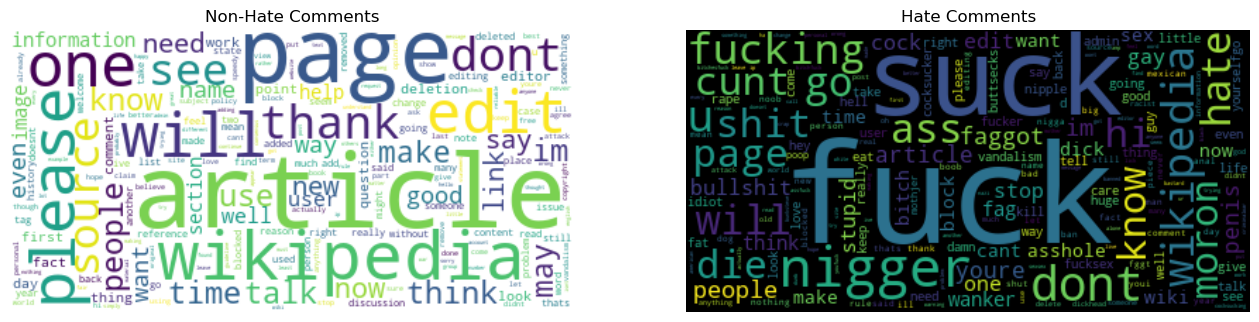

In [13]:
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_clean['tweet'][train.label == 0])
text_neg = " ".join(train_clean['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

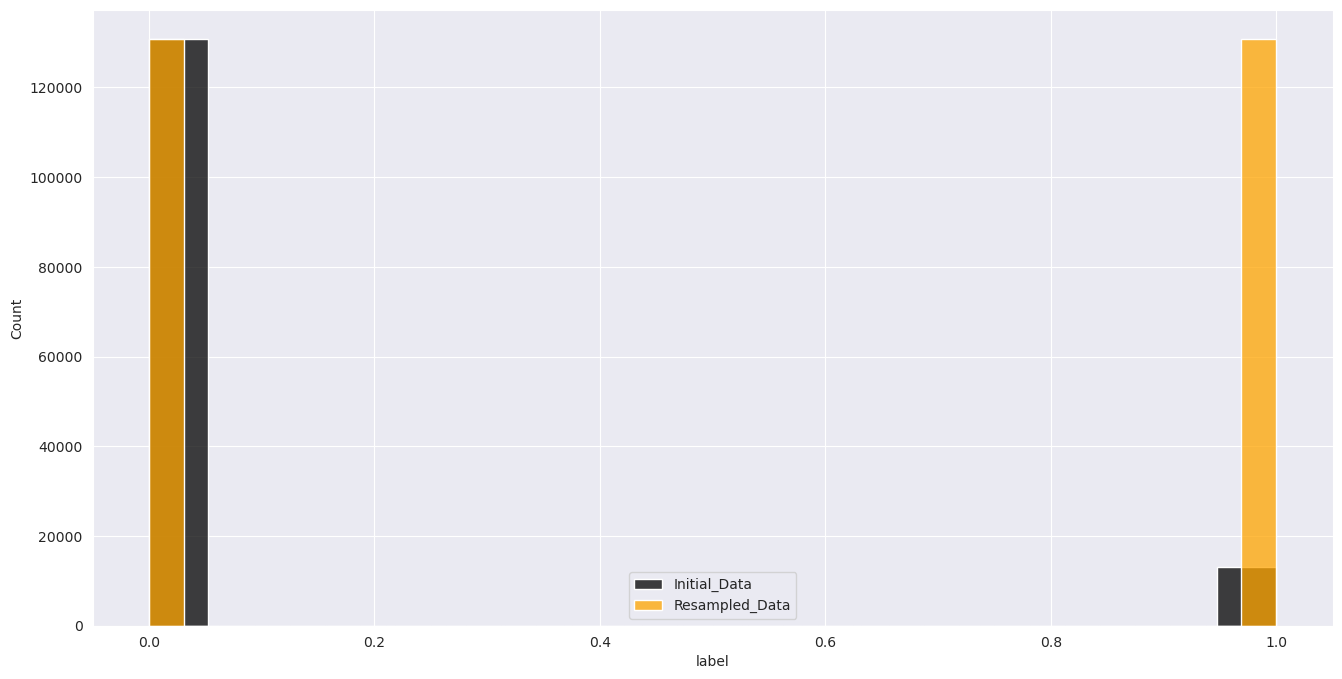

In [14]:
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.histplot(data = train['label'], color='black', legend=True)
sns.histplot(data = train_upsampled['label'], color = 'orange', legend=True)
plt.legend(['Initial_Data', 'Resampled_Data'])
plt.show()

--------------After Upsampling the Minority Class---------------


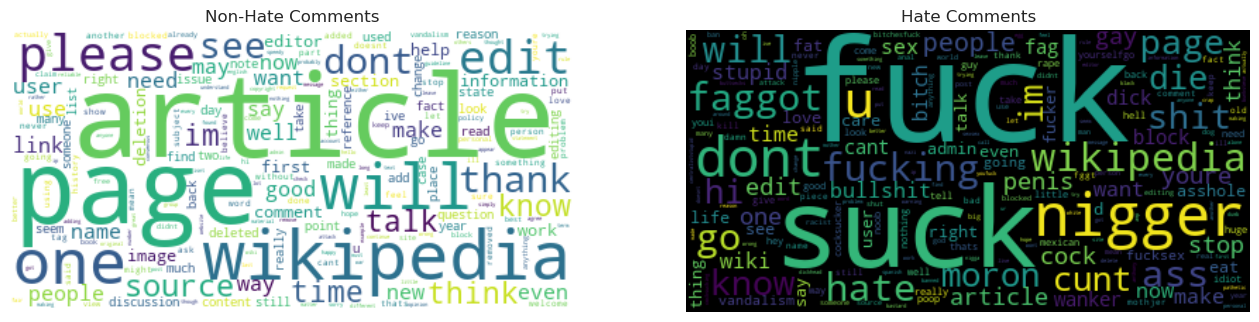

In [15]:
print('--------------After Upsampling the Minority Class---------------')

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_upsampled['tweet'][train.label == 0])
text_neg = " ".join(train_upsampled['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

In [16]:
dt_trasformed = train_upsampled[['label', 'tweet']]
y = dt_trasformed.iloc[:, :-1].values

In [17]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
y = np.array(ct.fit_transform(y))

y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [18]:
print(y.shape)

(261520, 2)


In [19]:
y_df = pd.DataFrame(y)
y_hate = np.array(y_df[0])
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [20]:
cv = CountVectorizer(max_features = 2000)
x = cv.fit_transform(train_upsampled['tweet']).toarray()
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
x.shape

(261520, 2000)

# Train & Test splitting the Data

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y_hate, test_size = 0.30, random_state = 1)

# **Testing With Different Models**
## Gaussian Naive Bayes, Decision Tree, K Nearest Neighbors, Random Forest, SVM

## Naive Bayes

In [23]:
# Using Naive Bayes Classifier

classifier_np = GaussianNB()

# Start timer
start_time = time.time()

classifier_np.fit(x_train, y_train)

# End timer
end_time = time.time()

In [24]:
# Calculate training time
training_time = end_time - start_time

print(f"Training time of Naive Bayes: {training_time:.6f} seconds")

Training time of Naive Bayes: 5.372058 seconds


In [25]:
# save the model to disk
filename = 'twitter_with_two_dataset_model_GaussianNB.sav'
pickle.dump(classifier_np, open(filename, 'wb'))

## Decision Tree

In [26]:
# Using Decision Tree

classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

# Start timer
start_time = time.time()

classifier_dt.fit(x_train, y_train)

# End timer
end_time = time.time()

In [27]:
# Calculate training time
training_time = end_time - start_time

print(f"Training time of Decision Tree: {training_time:.6f} seconds")

Training time of Decision Tree: 180.654425 seconds


In [28]:
# save the model to disk
filename = 'twitter_with_two_dataset_model_Decision_Tree.sav'
pickle.dump(classifier_dt, open(filename, 'wb'))

## K-Nearest Neighbors

In [29]:
# Using KNN

classifier_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

# Start timer
start_time = time.time()

classifier_knn.fit(x_train, y_train)

# End timer
end_time = time.time()

In [30]:
# Calculate training time
training_time = end_time - start_time

print(f"Training time of KNN: {training_time:.6f} seconds")

Training time of KNN: 0.014503 seconds


In [31]:
# save the model to disk
filename = 'twitter_with_two_dataset_model_KNN.sav'
pickle.dump(classifier_knn, open(filename, 'wb'))

## Logistic Regression

In [32]:
# Using Logistic Regression

classifier_lr = LogisticRegression(random_state = 0)

# Start timer
start_time = time.time()

classifier_lr.fit(x_train, y_train)

# End timer
end_time = time.time()

In [33]:
# Calculate training time
training_time = end_time - start_time

print(f"Training time of Logistic Regression: {training_time:.6f} seconds")

Training time of Logistic Regression: 32.261831 seconds


In [34]:
# save the model to disk
filename = 'twitter_with_two_dataset_model_Logistic_Regression.sav'
pickle.dump(classifier_lr, open(filename, 'wb'))

## Random Forest

In [35]:
# Using Random Forest

classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

# Start timer
start_time = time.time()

classifier_rf.fit(x_train, y_train)

# End timer
end_time = time.time()

In [36]:
# Calculate training time
training_time = end_time - start_time

print(f"Training time of Random Forest: {training_time:.6f} seconds")

Training time of Random Forest: 33.501667 seconds


In [37]:
# save the model to disk
filename = 'twitter_with_two_dataset_model_Random_Forest.sav'
pickle.dump(classifier_rf, open(filename, 'wb'))

## SVM

In [38]:
# Using Support Vector Machine

'''classifier_svm = svm.SVC(kernel = 'linear')

# Start timer
start_time = time.time()

classifier_svm.fit(x_train, y_train)

# End timer
end_time = time.time()'''

"classifier_svm = svm.SVC(kernel = 'linear')\n\n# Start timer\nstart_time = time.time()\n\nclassifier_svm.fit(x_train, y_train)\n\n# End timer\nend_time = time.time()"

In [39]:
'''# Calculate training time
training_time = end_time - start_time

print(f"Training time of SVM: {training_time:.6f} seconds")'''

'# Calculate training time\ntraining_time = end_time - start_time\n\nprint(f"Training time of SVM: {training_time:.6f} seconds")'

In [40]:
# save the model to disk
'''filename = 'twitter_with_two_dataset_model_SVM.sav'
pickle.dump(classifier_svm, open(filename, 'wb'))'''

"filename = 'twitter_with_two_dataset_model_SVM.sav'\npickle.dump(classifier_svm, open(filename, 'wb'))"

# Confusion Matrix for Different Models

## Naive Bayes

[[18011 21485]
 [  675 38285]]


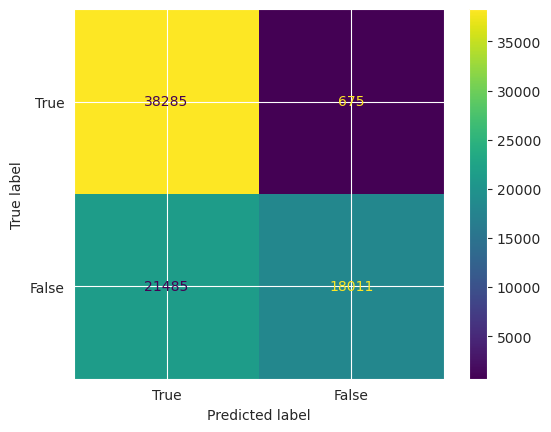

In [41]:
#Naive Bayes
y_pred_np = classifier_np.predict(x_test)
cm = confusion_matrix(y_test, y_pred_np)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_np, labels = [1,0]), display_labels = [True, False])
cm_display.plot()
plt.show()

In [42]:
yhat_np = classifier_np.predict_proba(x_test)
print('y_hat_shape for Naive Bayes: ',yhat_np.shape)
yhat_np = yhat_np[:, 1]
fpr_np, tpr_np, _ = metrics.roc_curve(y_test, yhat_np)
auc_np = round(metrics.roc_auc_score(y_test, yhat_np), 4)

y_hat_shape for Naive Bayes:  (78456, 2)


## Decision Tree

[[39296   200]
 [ 2767 36193]]


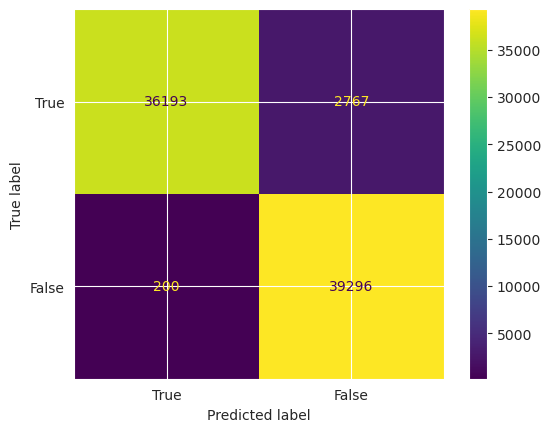

In [43]:
#Decision Tree
y_pred_dt = classifier_dt.predict(x_test)
cm = confusion_matrix(y_test, y_pred_dt)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_dt, labels = [1,0]), display_labels = [True, False])
cm_display.plot()
plt.show()

In [44]:
yhat_dt = classifier_dt.predict_proba(x_test)
print('y_hat_shape for Decision Tree: ',yhat_dt.shape)
yhat_dt = yhat_dt[:, 1]
fpr_dt, tpr_dt, _ = metrics.roc_curve(y_test, yhat_dt)
auc_dt = round(metrics.roc_auc_score(y_test, yhat_dt), 4)

y_hat_shape for Decision Tree:  (78456, 2)


## K-Nearest Neighbors

[[38910   586]
 [ 7470 31490]]


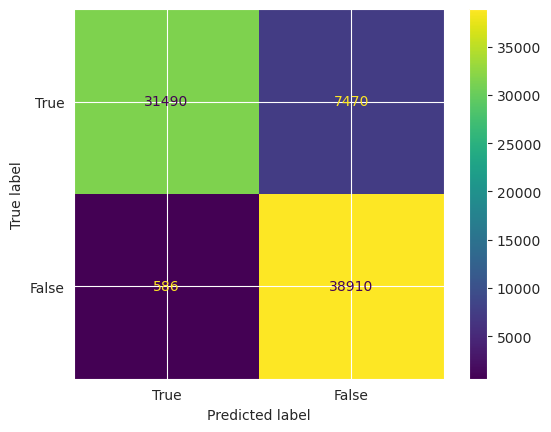

In [45]:
#KNN
y_pred_knn = classifier_knn.predict(x_test)
cm = confusion_matrix(y_test, y_pred_knn)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_knn, labels = [1,0]), display_labels = [True, False])
cm_display.plot()
plt.show()

In [46]:
yhat_knn = classifier_knn.predict_proba(x_test)
print('y_hat_shape for KNN: ',yhat_knn.shape)
yhat_knn = yhat_knn[:, 1]
fpr_knn, tpr_knn, _ = metrics.roc_curve(y_test, yhat_knn)
auc_knn = round(metrics.roc_auc_score(y_test, yhat_knn), 4)

y_hat_shape for KNN:  (78456, 2)


## Logistic Regression

[[33402  6094]
 [ 3524 35436]]


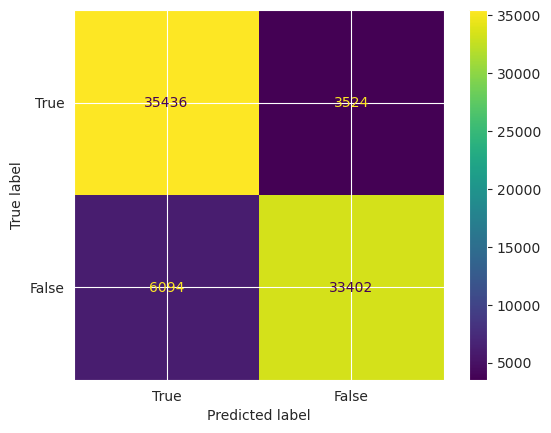

In [47]:
#Logistic Regression
y_pred_lr=classifier_lr.predict(x_test)
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_lr, labels = [1,0]), display_labels = [True, False])
cm_display.plot()
plt.show()

In [48]:
yhat_lr = classifier_lr.predict_proba(x_test)
print('y_hat_shape for Logistic Regression: ',yhat_lr.shape)
yhat_lr = yhat_lr[:, 1]
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test, yhat_lr)
auc_lr = round(metrics.roc_auc_score(y_test, yhat_lr), 4)

y_hat_shape for Logistic Regression:  (78456, 2)


## Random Forest

[[39306   190]
 [ 1246 37714]]


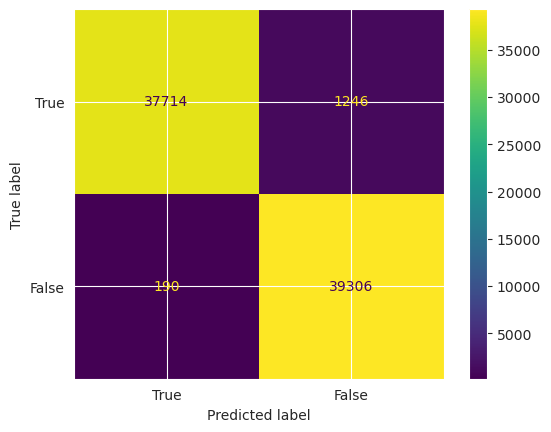

In [49]:
#Random Forest
y_pred_rf = classifier_rf.predict(x_test)
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_rf, labels = [1,0]), display_labels = [True, False])
cm_display.plot()
plt.show()

In [50]:
yhat_rf = classifier_rf.predict_proba(x_test)
print('y_hat_shape for Random Forest: ',yhat_rf.shape)
yhat_rf = yhat_rf[:, 1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, yhat_rf)
auc_rf = round(metrics.roc_auc_score(y_test, yhat_rf), 4)

y_hat_shape for Random Forest:  (78456, 2)


## Support Vector Machine

In [51]:
#SVM
'''y_pred_svm = classifier_svm.predict(x_test)
cm = confusion_matrix(y_test, y_pred_svm)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_svm, labels = [1,0]), display_labels = [True, False])
cm_display.plot()
plt.show()'''

'y_pred_svm = classifier_svm.predict(x_test)\ncm = confusion_matrix(y_test, y_pred_svm)\nprint(cm)\n\ncm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_svm, labels = [1,0]), display_labels = [True, False])\ncm_display.plot()\nplt.show()'

In [52]:
'''yhat_svm = classifier_svm.predict_proba(x_test)
print('y_hat_shape for SVM: ',yhat_svm.shape)
yhat_svm = yhat_svm[:, 1]
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_test, yhat_svm)
auc_svm = round(metrics.roc_auc_score(y_test, yhat_svm), 4)'''

"yhat_svm = classifier_svm.predict_proba(x_test)\nprint('y_hat_shape for SVM: ',yhat_svm.shape)\nyhat_svm = yhat_svm[:, 1]\nfpr_svm, tpr_svm, _ = metrics.roc_curve(y_test, yhat_svm)\nauc_svm = round(metrics.roc_auc_score(y_test, yhat_svm), 4)"

# Generating the Accuracy & F1 Score

In [53]:
rf_score = accuracy_score(y_test, y_pred_rf)
knn_score = accuracy_score(y_test, y_pred_knn)
#svm_score = accuracy_score(y_test, y_pred_svm)
lr_score = accuracy_score(y_test, y_pred_lr)
dt_score = accuracy_score(y_test, y_pred_dt)
np_score = accuracy_score(y_test, y_pred_np)

print ('--' * 20)
print('Random Forest Accuracy: ', str(rf_score))
print('F1 score: ', f1_score(y_test, y_pred_rf, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('K-Nearest Neighbors Accuracy: ', str(knn_score))
print('F1 score: ', f1_score(y_test, y_pred_knn, labels = [1,0]))
print ('--' * 20)
print ('')
'''print ('--' * 20)
print('Support Vector Machine Accuracy: ', str(svm_score))
print('F1 score: ', f1_score(y_test, y_pred_svm, labels = [1,0]))
print ('--' * 20)
print ('')'''
print ('--' * 20)
print('Logistic Regression Accuracy: ',str(lr_score))
print('F1 score: ', f1_score(y_test, y_pred_lr, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Decision Tree Accuracy: ', str(dt_score))
print('F1 score: ', f1_score(y_test, y_pred_dt, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Naive Bayes Accuracy: ', str(np_score))
print('F1 score: ', f1_score(y_test, y_pred_np, labels = [1,0]))
print ('--' * 20)
print ('')

----------------------------------------
Random Forest Accuracy:  0.9816967472213725
F1 score:  0.9813176519567026
----------------------------------------

----------------------------------------
K-Nearest Neighbors Accuracy:  0.8973182420719894
F1 score:  0.8865927135536911
----------------------------------------

----------------------------------------
Logistic Regression Accuracy:  0.8774089935760171
F1 score:  0.8805068952664927
----------------------------------------

----------------------------------------
Decision Tree Accuracy:  0.962182624655858
F1 score:  0.9606253234774992
----------------------------------------

----------------------------------------
Naive Bayes Accuracy:  0.7175486897114306
F1 score:  0.7755494783753671
----------------------------------------



# Generating the performance metrics of several other models using Lazy Predict

### Classification models

In [54]:
'''clf = LazyClassifier(verbose=0,predictions=True)
lazymodels,predictions = clf.fit(x_train, x_test, y_train, y_test)
lazymodels'''

'clf = LazyClassifier(verbose=0,predictions=True)\nlazymodels,predictions = clf.fit(x_train, x_test, y_train, y_test)\nlazymodels'

### Regresson Models

In [55]:
'''reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
reggmodels, predictions = reg.fit(x_train, x_test, y_train, y_test)
reggmodels'''

'reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)\nreggmodels, predictions = reg.fit(x_train, x_test, y_train, y_test)\nreggmodels'

# Precision-Recall Curve & ROC Curve generation for the trained models

Text(0.5, 1.0, 'Precision-Recall curve')

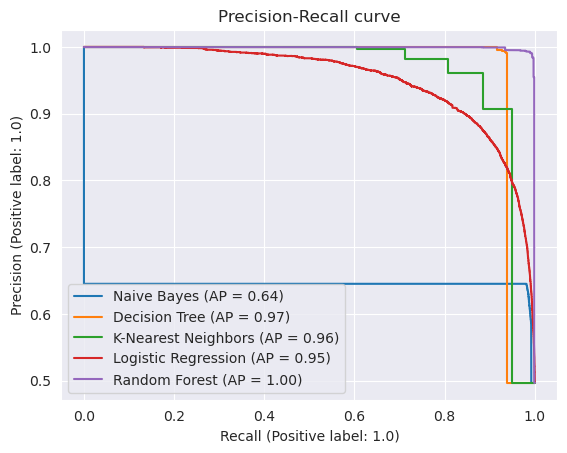

In [56]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(classifier_np, x_test, y_test, ax = plt.gca(),name = "Naive Bayes")

plot_precision_recall_curve(classifier_dt, x_test, y_test, ax = plt.gca(),name = "Decision Tree")

plot_precision_recall_curve(classifier_knn, x_test, y_test, ax = plt.gca(),name = "K-Nearest Neighbors")

plot_precision_recall_curve(classifier_lr, x_test, y_test, ax = plt.gca(),name = "Logistic Regression")

plot_precision_recall_curve(classifier_rf, x_test, y_test, ax = plt.gca(),name = "Random Forest")

plt.title('Precision-Recall curve')

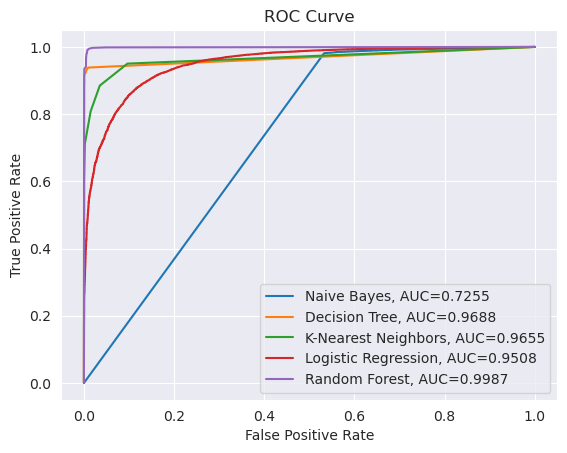

In [57]:
plt.plot(fpr_np,tpr_np,label="Naive Bayes, AUC="+str(auc_np))
plt.plot(fpr_dt,tpr_dt,label="Decision Tree, AUC="+str(auc_dt))
plt.plot(fpr_knn,tpr_knn,label="K-Nearest Neighbors, AUC="+str(auc_knn))
plt.plot(fpr_lr,tpr_lr,label="Logistic Regression, AUC="+str(auc_lr))
plt.plot(fpr_rf,tpr_rf,label="Random Forest, AUC="+str(auc_rf))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')

#add legend
plt.legend()